In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 进度条

# 10-臂赌博机环境（带随机游走的非平稳环境）
class Bandit:
    def __init__(self, num_arms=10):
        self.num_arms = num_arms
        self.q_star = np.zeros(num_arms)  # 初始时所有 q*(a) 设为 0

    def get_reward(self, action):
        return np.random.normal(self.q_star[action], 1)  # N(q*(a), 1)

    def update_q_star(self):
        """ 每一步后，所有 q*(a) 进行随机游走 """
        self.q_star += np.random.normal(0, 0.01, self.num_arms)

    def optimal_action(self):
        """ 返回当前 q*(a) 最高的拉杆索引 """
        return np.argmax(self.q_star)

# 智能体（ε-greedy 策略，支持三种 Q 估计方法）
class Agent:
    def __init__(self, num_arms=10, epsilon=0.1, alpha=None, adaptive=False):
        self.epsilon = epsilon
        self.alpha = alpha  # None 代表样本平均法，固定数值代表固定步长
        self.adaptive = adaptive  # 是否使用自适应步长 alpha_t = 1/t
        self.q_estimates = np.zeros(num_arms)  # 估计的 Q 值
        self.action_counts = np.zeros(num_arms)  # 记录每个动作的选择次数

    def select_action(self):
        """ ε-greedy 选择策略 """
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.q_estimates))  # 10% 随机探索
        else:
            return np.argmax(self.q_estimates)  # 90% 选择当前最优动作

    def update(self, action, reward):
        """ 更新 Q 估计值 """
        self.action_counts[action] += 1
        if self.adaptive:  # 自适应步长 α_t = 1/t
            alpha = 1 / self.action_counts[action]
        elif self.alpha is None:  # 样本平均法 α_t = 1/N_t
            alpha = 1 / self.action_counts[action]
        else:  # 固定步长 α = 0.1
            alpha = self.alpha
        self.q_estimates[action] += alpha * (reward - self.q_estimates[action])

# 运行实验
def run_experiment(num_steps=10000, num_experiments=2000, epsilon=0.1, alpha=None, adaptive=False):
    avg_rewards = np.zeros(num_steps)
    optimal_action_pct = np.zeros(num_steps)

    for _ in tqdm(range(num_experiments), desc="Running Experiments"):
        bandit = Bandit()
        agent = Agent(epsilon=epsilon, alpha=alpha, adaptive=adaptive)
        optimal_action = bandit.optimal_action()

        for step in range(num_steps):
            action = agent.select_action()
            reward = bandit.get_reward(action)
            agent.update(action, reward)
            bandit.update_q_star()  # q*(a) 进行随机游走

            avg_rewards[step] += reward
            optimal_action_pct[step] += (action == bandit.optimal_action())

    avg_rewards /= num_experiments
    optimal_action_pct = (optimal_action_pct / num_experiments) * 100  # 转换为百分比
    return avg_rewards, optimal_action_pct



run experiment:

In [5]:
# 运行实验，比较三种 Q 估计方法
num_steps = 10000
num_experiments = 2000
epsilon = 0.1

# 1️⃣ 样本平均法
print("Sample Average - Incrementally Computed: ")
rewards_sample_avg, optimal_sample_avg = run_experiment(num_steps, num_experiments, epsilon, alpha=None)

# 2️⃣ 固定步长 α=0.1
print("Fixed Step-Size α=0.1: ")
rewards_const_alpha, optimal_const_alpha = run_experiment(num_steps, num_experiments, epsilon, alpha=0.1)

# 3️⃣ 自适应步长 α_t = 1/t
print("Adaptive Step-Size α_t = 1/t: ")
rewards_adaptive, optimal_adaptive = run_experiment(num_steps, num_experiments, epsilon, adaptive=True)


Sample Average - Incrementally Computed: 


Running Experiments: 100%|██████████| 2000/2000 [03:27<00:00,  9.62it/s]


Fixed Step-Size α=0.1: 


Running Experiments: 100%|██████████| 2000/2000 [03:13<00:00, 10.34it/s]


Adaptive Step-Size α_t = 1/t: 


Running Experiments: 100%|██████████| 2000/2000 [03:19<00:00, 10.02it/s]


draw:

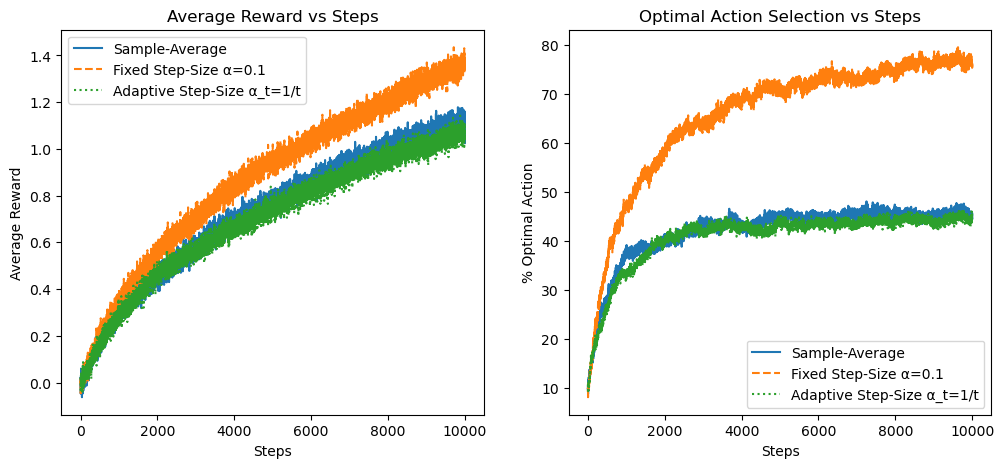

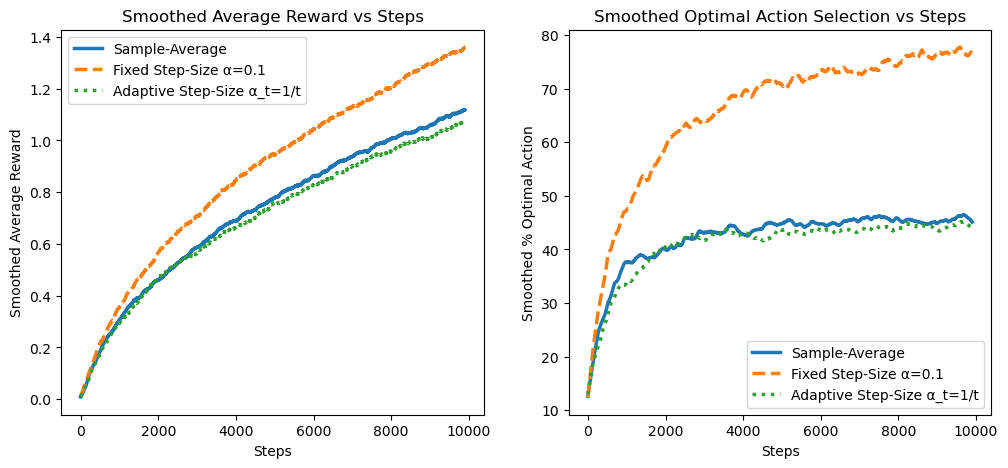

In [8]:

# 🎨 **绘制结果**
plt.figure(figsize=(12, 5))

# 平均奖励曲线
plt.subplot(1, 2, 1)
plt.plot(rewards_sample_avg, linestyle="-", linewidth=1.5, label='Sample-Average')
plt.plot(rewards_const_alpha, linestyle="--", linewidth=1.5, label='Fixed Step-Size α=0.1')
plt.plot(rewards_adaptive, linestyle=":", linewidth=1.5, label='Adaptive Step-Size α_t=1/t')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs Steps")

# 最优动作选择率曲线
plt.subplot(1, 2, 2)
plt.plot(optimal_sample_avg, linestyle="-", linewidth=1.5, label='Sample-Average')
plt.plot(optimal_const_alpha, linestyle="--", linewidth=1.5, label='Fixed Step-Size α=0.1')
plt.plot(optimal_adaptive, linestyle=":", linewidth=1.5, label='Adaptive Step-Size α_t=1/t')
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.legend()
plt.title("Optimal Action Selection vs Steps")

plt.show()

# 🎨 **新图：使用滑动平均展示更平滑的趋势**
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

x_smooth = np.arange(len(moving_average(rewards_sample_avg)))

plt.figure(figsize=(12, 5))

# 平均奖励曲线（平滑版）
plt.subplot(1, 2, 1)
plt.plot(x_smooth, moving_average(rewards_sample_avg), linestyle="-", linewidth=2.5, label='Sample-Average')
plt.plot(x_smooth, moving_average(rewards_const_alpha), linestyle="--", linewidth=2.5, label='Fixed Step-Size α=0.1')
plt.plot(x_smooth, moving_average(rewards_adaptive), linestyle=":", linewidth=2.5, label='Adaptive Step-Size α_t=1/t')
plt.xlabel("Steps")
plt.ylabel("Smoothed Average Reward")
plt.legend()
plt.title("Smoothed Average Reward vs Steps")

# 最优动作选择率曲线（平滑版）
plt.subplot(1, 2, 2)
plt.plot(x_smooth, moving_average(optimal_sample_avg), linestyle="-", linewidth=2.5, label='Sample-Average')
plt.plot(x_smooth, moving_average(optimal_const_alpha), linestyle="--", linewidth=2.5, label='Fixed Step-Size α=0.1')
plt.plot(x_smooth, moving_average(optimal_adaptive), linestyle=":", linewidth=2.5, label='Adaptive Step-Size α_t=1/t')
plt.xlabel("Steps")
plt.ylabel("Smoothed % Optimal Action")
plt.legend()
plt.title("Smoothed Optimal Action Selection vs Steps")

plt.show()


Sliding Window:

In [9]:
# 🎯 **补充代码：滑动窗口 Q 估计**
from collections import deque

# 🏆 **修改智能体（Agent）类，增加 Sliding Window 方法**
class Agent:
    def __init__(self, num_arms=10, epsilon=0.1, alpha=None, window_size=None):
        self.epsilon = epsilon
        self.alpha = alpha  # None 代表样本平均法，固定数值代表 α=0.1
        self.window_size = window_size  # 滑动窗口大小
        self.q_estimates = np.zeros(num_arms)  # 估计的 Q 值
        self.action_counts = np.zeros(num_arms)  # 记录每个动作的选择次数
        self.reward_windows = [deque(maxlen=window_size) for _ in range(num_arms)] if window_size else None  # 滑动窗口

    def select_action(self):
        """ ε-greedy 选择策略 """
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.q_estimates))  # 10% 随机探索
        else:
            return np.argmax(self.q_estimates)  # 90% 选择当前最优动作

    def update(self, action, reward):
        """ 更新 Q 估计值 """
        self.action_counts[action] += 1

        if self.window_size:  # 使用滑动窗口更新
            self.reward_windows[action].append(reward)
            self.q_estimates[action] = np.mean(self.reward_windows[action])
        elif self.alpha is None:  # 样本平均法
            alpha = 1 / self.action_counts[action]
            self.q_estimates[action] += alpha * (reward - self.q_estimates[action])
        else:  # 固定步长 α=0.1
            self.q_estimates[action] += self.alpha * (reward - self.q_estimates[action])

# 🎯 **补充：运行实验支持滑动窗口**
def run_experiment(num_steps=10000, num_experiments=2000, epsilon=0.1, alpha=None, window_size=None):
    avg_rewards = np.zeros(num_steps)
    optimal_action_pct = np.zeros(num_steps)

    for _ in tqdm(range(num_experiments), desc="Running Experiments"):
        bandit = Bandit()
        agent = Agent(epsilon=epsilon, alpha=alpha, window_size=window_size)
        optimal_action = bandit.optimal_action()

        for step in range(num_steps):
            action = agent.select_action()
            reward = bandit.get_reward(action)
            agent.update(action, reward)
            bandit.update_q_star()  # q*(a) 进行随机游走

            avg_rewards[step] += reward
            optimal_action_pct[step] += (action == bandit.optimal_action())

    avg_rewards /= num_experiments
    optimal_action_pct = (optimal_action_pct / num_experiments) * 100  # 转换为百分比
    return avg_rewards, optimal_action_pct

# 🎯 **运行实验**
num_steps = 10000
num_experiments = 2000
epsilon = 0.1

print("Sliding Window (N=100):")
rewards_window, optimal_window = run_experiment(num_steps, num_experiments, epsilon, window_size=100)


Sliding Window (N=100):


Running Experiments: 100%|██████████| 2000/2000 [10:38<00:00,  3.13it/s]


对比新的曲线：

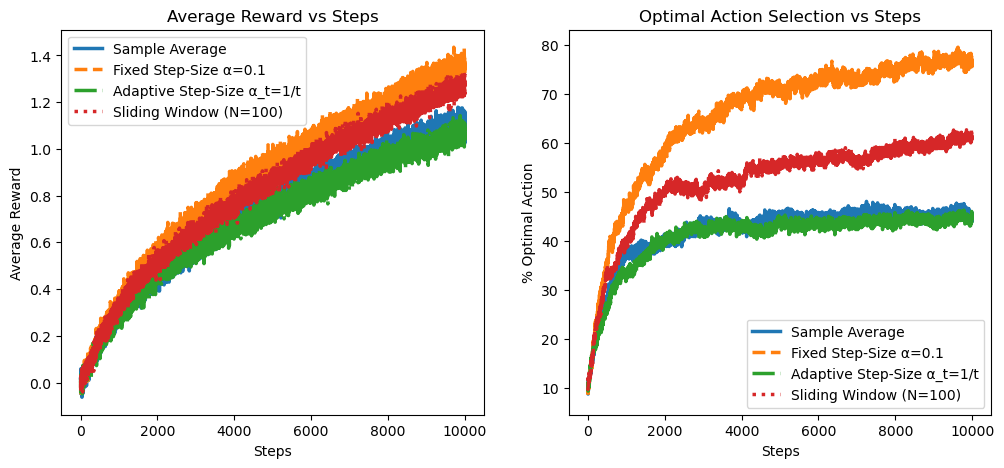

In [10]:

# 🎨 **增加滑动窗口曲线**
plt.figure(figsize=(12, 5))

# 平均奖励曲线
plt.subplot(1, 2, 1)
plt.plot(rewards_sample_avg, linestyle="-", linewidth=2.5, label='Sample Average')
plt.plot(rewards_const_alpha, linestyle="--", linewidth=2.5, label='Fixed Step-Size α=0.1')
plt.plot(rewards_adaptive, linestyle="-.", linewidth=2.5, label='Adaptive Step-Size α_t=1/t')
plt.plot(rewards_window, linestyle=":", linewidth=2.5, label='Sliding Window (N=100)')
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Average Reward vs Steps")

# 最优动作选择率曲线
plt.subplot(1, 2, 2)
plt.plot(optimal_sample_avg, linestyle="-", linewidth=2.5, label='Sample Average')
plt.plot(optimal_const_alpha, linestyle="--", linewidth=2.5, label='Fixed Step-Size α=0.1')
plt.plot(optimal_adaptive, linestyle="-.", linewidth=2.5, label='Adaptive Step-Size α_t=1/t')
plt.plot(optimal_window, linestyle=":", linewidth=2.5, label='Sliding Window (N=100)')
plt.xlabel("Steps")
plt.ylabel("% Optimal Action")
plt.legend()
plt.title("Optimal Action Selection vs Steps")

plt.show()



更便于看的图：

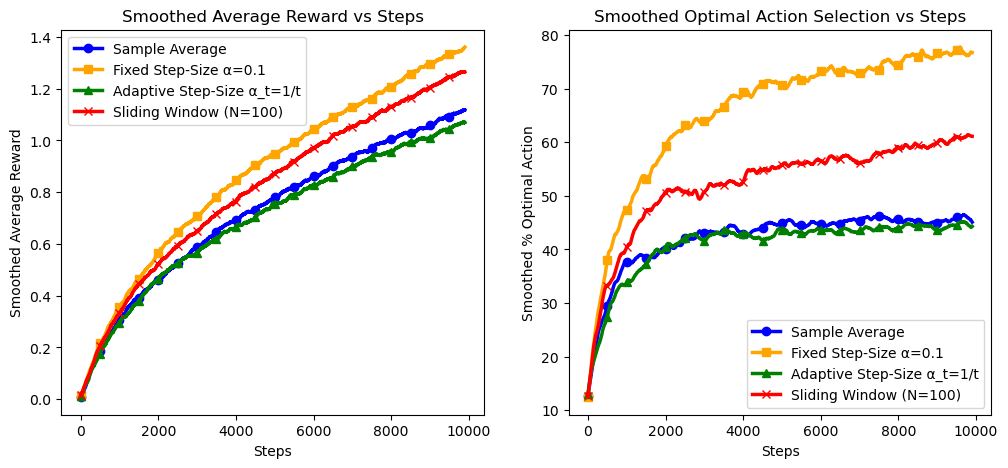

In [12]:
# 🎨 **新图：使用滑动平均展示更平滑的趋势**
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

x_smooth = np.arange(len(moving_average(rewards_sample_avg)))

plt.figure(figsize=(12, 5))

# 统一线条风格，使用不同的标记（marker）
markers = ["o", "s", "^", "x"]  # 圆圈、方块、三角形、叉号
labels = [
    "Sample Average",
    "Fixed Step-Size α=0.1",
    "Adaptive Step-Size α_t=1/t",
    "Sliding Window (N=100)"
]
colors = ["blue", "orange", "green", "red"]  # 颜色保持区分
data = [
    (rewards_sample_avg, optimal_sample_avg),
    (rewards_const_alpha, optimal_const_alpha),
    (rewards_adaptive, optimal_adaptive),
    (rewards_window, optimal_window)
]

# 平均奖励曲线（平滑版）
plt.subplot(1, 2, 1)
for (rewards, _), marker, label, color in zip(data, markers, labels, colors):
    plt.plot(x_smooth, moving_average(rewards), marker=marker, markevery=500, linewidth=2.5, label=label, color=color)
plt.xlabel("Steps")
plt.ylabel("Smoothed Average Reward")
plt.legend()
plt.title("Smoothed Average Reward vs Steps")

# 最优动作选择率曲线（平滑版）
plt.subplot(1, 2, 2)
for (_, optimal), marker, label, color in zip(data, markers, labels, colors):
    plt.plot(x_smooth, moving_average(optimal), marker=marker, markevery=500, linewidth=2.5, label=label, color=color)
plt.xlabel("Steps")
plt.ylabel("Smoothed % Optimal Action")
plt.legend()
plt.title("Smoothed Optimal Action Selection vs Steps")

plt.show()
